In [1]:
# Step 1 – Environment Setup and AWS Configuration

# In this step I set up the basic Python environment and connect to AWS. I load the core libraries (boto3, SageMaker, pandas), initialize a SageMaker session, and define the S3 bucket/path where the UNSW_NB15 dataset is stored.


In [2]:
# Imports and basic setup

# AWS and SageMaker libraries
import boto3
import sagemaker
from sagemaker import get_execution_role

# Data handling
import pandas as pd

print("Libraries loaded")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Libraries loaded


In [3]:
# AWS session and S3 path configuration

# Initialize SageMaker session and basic S3 paths
session = sagemaker.Session()
region = session.boto_region_name
role = get_execution_role()

print("Region:", region)
print("Execution role:", role)

# S3 settings for the raw UNSW_NB15 dataset
bucket = "msml650-project"
raw_prefix = "raw-data"
raw_filename = "UNSW_NB15_training-set.csv"

raw_s3_path = f"s3://{bucket}/{raw_prefix}/{raw_filename}"
print("Raw S3 path:", raw_s3_path)

Region: us-east-1
Execution role: arn:aws:iam::710271916019:role/SageMakerCybersecurityRole
Raw S3 path: s3://msml650-project/raw-data/UNSW_NB15_training-set.csv


In [4]:
# Step 2 – Data Loading

# Here I load the UNSW_NB15 training CSV directly from S3 into a pandas DataFrame and make a working copy. This is the raw input that I will clean and transform before training any model.


In [5]:
# Load dataset from S3 into a DataFrame

print("About to read CSV from S3...")

df = pd.read_csv(raw_s3_path)

print("Read complete.")
print("Dataset shape:", df.shape)

df.head()

About to read CSV from S3...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:298: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


Read complete.
Dataset shape: (175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [6]:
# Create a working copy of the original DataFrame

data = df.copy()
print("Original dataset shape:", data.shape)

data.head()

Original dataset shape: (175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [7]:
# Step 3 – Data Preprocessing and Feature Engineering

# In this step I prepare the dataset for modeling. I drop IDs and non-predictive columns, create a few simple traffic features (byte ratio and flow intensity), separate features from the target label, one-hot encode categorical fields, and build a clean train/test split with consistent feature columns.

In [8]:
# Feature cleanup and simple feature engineering

# Drop columns that are not needed for modeling
drop_cols = ["id", "attack_cat"]

for col in drop_cols:
    if col in data.columns:
        data = data.drop(columns=[col])

# Create basic engineered features
data["byte_ratio"] = (data["sbytes"] + 1) / (data["dbytes"] + 1)
data["flow_intensity"] = (data["sbytes"] + data["dbytes"]) / (data["dur"] + 1e-6)

print("Shape after cleanup and feature engineering:", data.shape)

# Preview engineered features
data[["sbytes", "dbytes", "dur", "byte_ratio", "flow_intensity"]].head()

Shape after cleanup and feature engineering: (175341, 45)


,sbytes,dbytes,dur,byte_ratio,flow_intensity
0,258,172,0.121478,1.497110,3539.706451
1,734,42014,0.649902,0.017494,65775.969645
2,364,13186,1.623129,0.027679,8348.068239
3,628,770,1.681642,0.815824,831.329836
4,534,268,0.449454,1.988848,1784.383309


In [ ]:
# Split features and target label

target_col = "label"

X = data.drop(columns=[target_col])
y = data[target_col]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (175341, 44)
Target vector shape: (175341,)


In [10]:
# One-hot encode categorical columns

cat_cols = ["proto", "service", "state"]

X_encoded = pd.get_dummies(X, columns=cat_cols, dummy_na=True)

print("Encoded feature matrix shape:", X_encoded.shape)

X_encoded.head()

Encoded feature matrix shape: (175341, 199)


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no,state_nan
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,False,False,True,False,False,False,False,False,False,False
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,False,False,True,False,False,False,False,False,False,False
2,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,...,False,False,True,False,False,False,False,False,False,False
3,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,...,False,False,True,False,False,False,False,False,False,False
4,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,...,False,False,True,False,False,False,False,False,False,False


In [11]:
# Train/test split, align columns, and drop all-zero features

from sklearn.model_selection import train_test_split

# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("Train X (before align):", X_train.shape)
print("Test X (before align):", X_test.shape)
print("Train y:", y_train.shape)
print("Test y:", y_test.shape)

# Align columns so both train and test have EXACT SAME columns and order
feature_cols = X_encoded.columns

X_train = X_train.reindex(columns=feature_cols, fill_value=0)
X_test  = X_test.reindex(columns=feature_cols, fill_value=0)

print("After align - Train X:", X_train.shape)
print("After align - Test X:", X_test.shape)

# Drop any feature that is ALL ZERO in TRAIN
non_zero_mask = (X_train != 0).any(axis=0)     # True if column has any non-zero value in train
kept_cols = X_train.columns[non_zero_mask]

X_train = X_train[kept_cols]
X_test  = X_test[kept_cols]

print("After dropping all-zero train columns:")
print("Train X:", X_train.shape)
print("Test X:", X_test.shape)

Train X (before align): (140272, 199)
Test X (before align): (35069, 199)
Train y: (140272,)
Test y: (35069,)
After align - Train X: (140272, 199)
After align - Test X: (35069, 199)
After dropping all-zero train columns:
Train X: (140272, 194)
Test X: (35069, 194)


In [12]:
!pip install --no-cache-dir "xgboost==2.1.0" shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 178.4 MB/s  0:00:00


In [13]:
# Step 4 – Generate a Malicious Test Sample for Streaming

# Here I pick one example from the test set that is labeled as malicious and export it as a small CSV file. I then upload this file to the `incoming-events/` S3 prefix, which is used later to trigger the Lambda function and test the end-to-end threat detection pipeline.


In [14]:
# Build a single malicious sample and save it as CSV (for S3/Lambda test)

import pandas as pd

# 1) Pick one malicious sample (label == 1)
malicious_idx = y_test[y_test == 1].index[0]
sample = X_test.loc[[malicious_idx]].copy()

print("Original dtypes:")
print(sample.dtypes.head(20))

# 2) Convert boolean columns to 0/1
bool_cols = sample.select_dtypes(include=["bool"]).columns
print("\nBoolean columns:", len(bool_cols))

sample[bool_cols] = sample[bool_cols].astype(int)

# 3) Save as unlabeled CSV (no header, no index)
local_test_file = "test_event.csv"
sample.to_csv(local_test_file, header=False, index=False)

print("\nWrote:", local_test_file)

# 4) Double-check the file contents (should be only numbers)
with open(local_test_file, "r") as f:
    print("\nFile contents:")
    print(f.read())

Original dtypes:
dur       float64
spkts       int64
dpkts       int64
sbytes      int64
dbytes      int64
rate      float64
sttl        int64
dttl        int64
sload     float64
dload     float64
sloss       int64
dloss       int64
sinpkt    float64
dinpkt    float64
sjit      float64
djit      float64
swin        int64
stcpb       int64
dtcpb       int64
dwin        int64
dtype: object

Boolean columns: 153

Wrote: test_event.csv

File contents:
1.959922,10,10,864,1754,9.694264,254,252,3175.636719,6445.154785,2,2,217.769111,206.419219,12001.22141,392.087219,255,2981879522,886452321,255,0.247665,0.101484,0.146181,86,175,1,407,2,1,1,1,1,2,0,0,1,1,1,0,0.4928774928774929,1335.7667622656606,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0

In [15]:
# Upload the malicious CSV sample to S3 (incoming-events trigger)

import boto3

s3 = boto3.client("s3")
bucket = "msml650-project"
key = "incoming-events/test_event.csv"

s3.upload_file(local_test_file, bucket, key)
print("Uploaded to:", f"s3://{bucket}/{key}")

Uploaded to: s3://msml650-project/incoming-events/test_event.csv


In [68]:
import pandas as pd

# Pick one benign sample (label 0)
benign_idx = y_test[y_test == 0].index[0]
sample = X_test.loc[[benign_idx]].copy()

print("Original dtypes:")
print(sample.dtypes.head(20))   # just to sanity check

# If you still have many boolean columns, convert them to 0/1 ints
bool_cols = sample.select_dtypes(include="bool").columns
print("Boolean columns:", len(bool_cols))

if len(bool_cols) > 0:
    sample[bool_cols] = sample[bool_cols].astype(int)

# Save as unlabeled CSV (no header, no index), same as before
local_test_file = "test_event.csv"
sample.to_csv(local_test_file, header=False, index=False)

print("Wrote:", local_test_file)
print("\nFile contents:")
with open(local_test_file, "r") as f:
    print(f.read())

Original dtypes:
dur       float64
spkts       int64
dpkts       int64
sbytes      int64
dbytes      int64
rate      float64
sttl        int64
dttl        int64
sload     float64
dload     float64
sloss       int64
dloss       int64
sinpkt    float64
dinpkt    float64
sjit      float64
djit      float64
swin        int64
stcpb       int64
dtcpb       int64
dwin        int64
dtype: object
Boolean columns: 153
Wrote: test_event.csv

File contents:
0.001001,2,2,146,178,2997.002832,31,29,583416.5625,711288.6875,0,0,0.007,0.005,0.0,0.0,0,0,0,0,0.0,0.0,0.0,73,89,0,0,4,0,3,1,1,1,0,0,0,2,4,0,0.8212290502793296,323353.2934131737,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0



In [69]:
import boto3

s3 = boto3.client("s3")
bucket = "msml650-project"        # your bucket
key = "incoming-events/test_event.csv"

s3.upload_file(local_test_file, bucket, key)

print("Uploaded to:", f"s3://{bucket}/{key}")

Uploaded to: s3://msml650-project/incoming-events/test_event.csv


In [64]:
# Build a single "unknown" sample from X_test (no label used)

import pandas as pd
import numpy as np

# randomly choose one test row (unseen during training)
unknown_sample = X_test.sample(1, random_state=np.random.randint(0, 1_000_000)).copy()

print("Original dtypes:")
print(unknown_sample.dtypes.head(20))

# convert bools to 0/1
bool_cols = unknown_sample.select_dtypes(include=["bool"]).columns
print("\nBoolean columns:", len(bool_cols))

unknown_sample[bool_cols] = unknown_sample[bool_cols].astype(int)

local_test_file = "test_event.csv"
unknown_sample.to_csv(local_test_file, header=False, index=False)

print("\nWrote:", local_test_file)
with open(local_test_file, "r") as f:
    print("\nFile contents:")
    print(f.read())

Original dtypes:
dur       float64
spkts       int64
dpkts       int64
sbytes      int64
dbytes      int64
rate      float64
sttl        int64
dttl        int64
sload     float64
dload     float64
sloss       int64
dloss       int64
sinpkt    float64
dinpkt    float64
sjit      float64
djit      float64
swin        int64
stcpb       int64
dtcpb       int64
dwin        int64
dtype: object

Boolean columns: 153

Wrote: test_event.csv

File contents:
9e-06,2,0,114,0,111111.1072,254,0,50666664.0,0.0,0,0,0.009,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,57,0,0,0,34,2,19,18,18,34,0,0,0,18,34,0,115.0,11399999.999999998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0



In [65]:
import boto3

s3 = boto3.client("s3")
bucket = "msml650-project"
key = "incoming-events/test_event.csv"

s3.upload_file(local_test_file, bucket, key)
print("Uploaded to:", f"s3://{bucket}/{key}")

Uploaded to: s3://msml650-project/incoming-events/test_event.csv


In [66]:
sample = X_test.sample(1, random_state=42).copy()

# tweak some numeric features to make it look different
sample["dur"] = sample["dur"] * 3.0
sample["sbytes"] = sample["sbytes"] * 2
sample["dbytes"] = sample["dbytes"] // 2
sample["rate"] = sample["rate"] + 50

# convert bools to 0/1 as usual
bool_cols = sample.select_dtypes(include=["bool"]).columns
sample[bool_cols] = sample[bool_cols].astype(int)

local_test_file = "test_event.csv"
sample.to_csv(local_test_file, header=False, index=False)

In [67]:
import boto3

s3 = boto3.client("s3")
bucket = "msml650-project"
key = "incoming-events/test_event.csv"

s3.upload_file(local_test_file, bucket, key)
print("Uploaded to:", f"s3://{bucket}/{key}")

Uploaded to: s3://msml650-project/incoming-events/test_event.csv


In [22]:
# Step 5 – Prepare Training Data for SageMaker XGBoost

# In this step I convert the processed train and test splits into LibSVM format and upload them to S3. These files are used as inputs to the managed XGBoost training job and later for batch transform.


In [23]:
# Save train and test splits as local LibSVM files

from sklearn.datasets import dump_svmlight_file
import os

train_local_path = "/tmp/unsw_train.libsvm"
test_local_path = "/tmp/unsw_test.libsvm"

dump_svmlight_file(X_train, y_train, train_local_path, zero_based=True)
dump_svmlight_file(X_test,  y_test,  test_local_path, zero_based=True)

print("Saved local files:")
print(train_local_path, "exists?", os.path.exists(train_local_path))
print(test_local_path, "exists?", os.path.exists(test_local_path))

Saved local files:
/tmp/unsw_train.libsvm exists? True
/tmp/unsw_test.libsvm exists? True


In [24]:
# Upload LibSVM train and test files to S3

import boto3

s3 = boto3.client("s3")

train_s3_key = "xgboost-data/train/unsw_train.libsvm"
test_s3_key  = "xgboost-data/test/unsw_test.libsvm"

s3.upload_file(train_local_path, bucket, train_s3_key)
s3.upload_file(test_local_path,  bucket, test_s3_key)

train_s3_path = f"s3://{bucket}/{train_s3_key}"
test_s3_path  = f"s3://{bucket}/{test_s3_key}"

print("Train data uploaded to:", train_s3_path)
print("Test data uploaded to:",  test_s3_path)

Train data uploaded to: s3://msml650-project/xgboost-data/train/unsw_train.libsvm
Test data uploaded to: s3://msml650-project/xgboost-data/test/unsw_test.libsvm


In [25]:
# Step 6 – Train XGBoost Model on UNSW_NB15

# Here I configure the SageMaker XGBoost estimator, set the training hyperparameters for binary classification, wire the S3 LibSVM files as training input, and launch a managed training job on `ml.m5.large`.


In [26]:
# Configure the XGBoost estimator for SageMaker training

import sagemaker
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator

# XGBoost container image for your region
xgb_image = image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.5-1"  # stable version
)

print("XGBoost image URI:", xgb_image)

# Where to store model artifacts
output_path = f"s3://{bucket}/xgboost-output"

xgb = Estimator(
    image_uri=xgb_image,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",   # training instance type
    volume_size=5,                 # GB
    output_path=output_path,
    sagemaker_session=session,
)

# Hyperparameters for binary classification
xgb.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="auc",
    num_round=200,
    max_depth=5,
    eta=0.2,
    subsample=0.8,
    colsample_bytree=0.8
)

XGBoost image URI: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1


In [27]:
# Create training and validation inputs for SageMaker

# Training channel
train_input = TrainingInput(
    s3_data=train_s3_path,
    content_type="text/libsvm"
)

# Validation channel (optional, but set up here)
validation_input = TrainingInput(
    s3_data=test_s3_path,
    content_type="text/libsvm"
)

print("Train input:", train_s3_path)
print("Validation input:", test_s3_path)

Train input: s3://msml650-project/xgboost-data/train/unsw_train.libsvm
Validation input: s3://msml650-project/xgboost-data/test/unsw_test.libsvm


In [28]:
%%time

# Launch the XGBoost training job

xgb.fit(
    {
        "train": train_input
        # "validation": validation_input  # can be added if desired
    }
)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-12-01-14-47-22-569


2025-12-01 14:47:23 Starting - Starting the training job...
2025-12-01 14:47:39 Starting - Preparing the instances for training...
2025-12-01 14:48:02 Downloading - Downloading input data...
2025-12-01 14:48:47 Downloading - Downloading the training image......
2025-12-01 14:49:48 Training - Training image download completed. Training in progress...../miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-12-01 14:49:49.919 ip-10-0-228-83.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-12-01 14:49:49.941 ip-10-0-228-83.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-12-01:14:49:50:INFO] Imported framework sagemaker_xgboost_container.training
[2025-12-01:14:49:50:INFO] Failed to parse hyperparameter eval_metric value a

In [29]:
# Step 7 – Batch Inference and Model Evaluation

# After training, I run a SageMaker Batch Transform job on the test set. Then I download the prediction files from S3, convert scores to labels, and compute accuracy and a classification report to evaluate model quality.


In [30]:
# Run a batch transform job on the test set

import sagemaker
from sagemaker.inputs import TransformInput

session = sagemaker.Session()
role = sagemaker.get_execution_role()

print("Training job used:", xgb.latest_training_job.name)

bucket = "msml650-project"
train_prefix = "xgboost-data/train"
test_prefix  = "xgboost-data/test"

transformer = xgb.transformer(
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=f"s3://{bucket}/batch-transform-output/"
)

test_s3_path = f"s3://{bucket}/{test_prefix}/unsw_test.libsvm"
print("Test data for batch transform:", test_s3_path)

transformer.transform(
    data=test_s3_path,
    content_type="text/libsvm",
    split_type="Line"
)

transformer.wait()
print("Batch transform completed!")

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-12-01-14-51-41-096


Training job used: sagemaker-xgboost-2025-12-01-14-47-22-569


INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-12-01-14-51-41-685


Test data for batch transform: s3://msml650-project/xgboost-data/test/unsw_test.libsvm
................................./miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-12-01:14:57:12:INFO] No GPUs detected (normal if no gpus installed)
[2025-12-01:14:57:12:INFO] No GPUs detected (normal if no gpus installed)
[2025-12-01:14:57:12:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(p

In [31]:
# Download batch predictions and evaluate accuracy

import boto3
from sklearn.metrics import accuracy_score, classification_report

bucket = "msml650-project"
output_prefix = "batch-transform-output/"  # same as in transformer.output_path

s3 = boto3.client("s3")

# 1) List everything under the output prefix to see what SageMaker wrote
resp = s3.list_objects_v2(Bucket=bucket, Prefix=output_prefix)

if "Contents" not in resp:
    raise RuntimeError("No objects found under batch-transform-output/. Check the S3 console.")

print("Objects in batch-transform-output/:")
for obj in resp["Contents"]:
    print(" -", obj["Key"])

# 2) Collect all .out files (SageMaker may shard into multiple parts)
out_keys = [obj["Key"] for obj in resp["Contents"] if obj["Key"].endswith(".out")]

if not out_keys:
    raise RuntimeError("No .out prediction files found in batch-transform-output/")

print("\nPrediction files found:")
for k in out_keys:
    print(" -", k)

# 3) Download all .out files and aggregate predictions
preds = []
for i, key in enumerate(sorted(out_keys)):
    local_name = f"predictions_part_{i}.txt"
    print(f"\nDownloading {key} -> {local_name}")
    s3.download_file(bucket, key, local_name)

    with open(local_name, "r") as f:
        for line in f:
            line = line.strip()
            if line:  # skip empty lines
                preds.append(float(line))

# 4) Convert scores to 0/1 labels
y_pred = [1 if p > 0.5 else 0 for p in preds]

print("\nTotal prediction count:", len(y_pred))
print("True label count (y_test):", len(y_test))

# 5) Evaluate
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Objects in batch-transform-output/:
 - batch-transform-output/unsw_test.libsvm.out

Prediction files found:
 - batch-transform-output/unsw_test.libsvm.out


Total prediction count: 35069
True label count (y_test): 35069

Accuracy: 0.9580541218740198

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93     11200
           1       0.96      0.98      0.97     23869

    accuracy                           0.96     35069
   macro avg       0.96      0.95      0.95     35069
weighted avg       0.96      0.96      0.96     35069



In [32]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)
import numpy as np

# You already have:
# y_test: true labels, shape (35069,)
# preds or scores: list/array of probabilities from batch output

y_scores_bt = np.array(preds)       # or whatever your prob list is called
y_pred_bt = (y_scores_bt > 0.5).astype(int)

print("=== AWS Batch Transform – Model Metrics ===")
print(f"Test samples: {len(y_test)}")

print(f"Accuracy : {accuracy_score(y_test, y_pred_bt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_bt):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_bt):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred_bt):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_scores_bt):.4f}")

print("\nClassification report:\n")
print(classification_report(y_test, y_pred_bt, digits=4))

=== AWS Batch Transform – Model Metrics ===
Test samples: 35069
Accuracy : 0.9581
Precision: 0.9627
Recall   : 0.9762
F1-score : 0.9694
ROC-AUC  : 0.9935

Classification report:

              precision    recall  f1-score   support

           0     0.9476    0.9195    0.9333     11200
           1     0.9627    0.9762    0.9694     23869

    accuracy                         0.9581     35069
   macro avg     0.9552    0.9478    0.9514     35069
weighted avg     0.9579    0.9581    0.9579     35069



In [33]:
# Step 8 – Real-Time Endpoint Deployment and Live Test

# In this step I deploy the trained XGBoost model as a real-time SageMaker endpoint. I then send a small batch of test traffic through the endpoint to verify that the model is responding correctly and to compute a simple live accuracy on a few samples.


In [34]:
# Deploy the trained model as a real-time SageMaker endpoint

from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Reuse the same session and role
session = sagemaker.Session()
region = session.boto_region_name
role = sagemaker.get_execution_role()

print("Region:", region)
print("Role:", role)
print("Latest training job:", xgb.latest_training_job.name)

# Choose an endpoint name
endpoint_name = "unsw-xgb-endpoint"

# Deploy the trained XGBoost model as a real-time endpoint
predictor = xgb.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name
)

# Configure I/O formats (send CSV row, receive JSON)
predictor.serializer = CSVSerializer()          # send comma-separated values
predictor.deserializer = JSONDeserializer()     # parse JSON response

print(f"Deployed endpoint name: {endpoint_name}")

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-12-01-14-58-17-757


Region: us-east-1
Role: arn:aws:iam::710271916019:role/SageMakerCybersecurityRole
Latest training job: sagemaker-xgboost-2025-12-01-14-47-22-569


INFO:sagemaker:Creating endpoint-config with name unsw-xgb-endpoint
INFO:sagemaker:Creating endpoint with name unsw-xgb-endpoint


------!Deployed endpoint name: unsw-xgb-endpoint


In [35]:
# Send a small sample to the live endpoint and check accuracy

import numpy as np
import json
from sagemaker.predictor import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import StringDeserializer
from sklearn.metrics import accuracy_score, classification_report

# 1. Reuse your existing X_test / y_test
print("X_test shape:", X_test.shape)
print("y_test length:", len(y_test))

# Take first 20 samples from X_test
n_samples = 20
X_sample = X_test.iloc[:n_samples].copy()

# Convert everything to float so there are no bools/strings
X_sample = X_sample.astype(float)
y_true = y_test.iloc[:n_samples].values
print(f"Using {n_samples} samples for live endpoint test")

# 2. Build CSV payload (no header, comma-separated features)
lines = []
for _, row in X_sample.iterrows():
    lines.append(",".join(str(v) for v in row.values))

payload = "\n".join(lines)
print("Sample payload preview (first line):")
print(lines[0][:200], "...")

# 3. Create a Predictor for your deployed endpoint
endpoint_name = "unsw-xgb-endpoint"

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=session
)

predictor.serializer = IdentitySerializer("text/csv")
predictor.deserializer = StringDeserializer()

# 4. Call the endpoint
raw_result = predictor.predict(payload)
print("Raw result (truncated):", raw_result[:200], "...")

# Parse JSON response
resp = json.loads(raw_result)
pred_scores = np.array([p["score"] for p in resp["predictions"]])

# 5. Convert scores to 0/1 labels
y_pred = (pred_scores > 0.5).astype(int)

print("\nRaw scores (first 10):", pred_scores[:10])
print("Predicted labels (first 10):", y_pred[:10])
print("True labels      (first 10):", y_true[:10])

# 6. Simple accuracy on this small sample
acc = accuracy_score(y_true, y_pred)
print(f"\nEndpoint sample accuracy on {n_samples} points: {acc:.4f}")
print("\nClassification report on sample:\n",
      classification_report(y_true, y_pred, digits=4))

X_test shape: (35069, 194)
y_test length: 35069
Using 20 samples for live endpoint test
Sample payload preview (first line):
1.959922,10.0,10.0,864.0,1754.0,9.694264,254.0,252.0,3175.636719,6445.154785,2.0,2.0,217.769111,206.419219,12001.22141,392.087219,255.0,2981879522.0,886452321.0,255.0,0.247665,0.101484,0.146181,86.0,1 ...
Raw result (truncated): {"predictions": [{"score": 0.9898970127105713}, {"score": 0.5471231341362}, {"score": 0.5786111950874329}, {"score": 0.9932340979576111}, {"score": 0.8508440852165222}, {"score": 0.999263346195221}, { ...

Raw scores (first 10): [0.98989701 0.54712313 0.5786112  0.9932341  0.85084409 0.99926335
 0.97153091 0.90524614 0.87213582 0.99782735]
Predicted labels (first 10): [1 1 1 1 1 1 1 1 1 1]
True labels      (first 10): [1 1 1 1 1 1 1 1 1 1]

Endpoint sample accuracy on 20 points: 0.9500

Classification report on sample:
               precision    recall  f1-score   support

           0     1.0000    0.5000    0.6667         2
           

In [36]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)

import numpy as np

# pred_scores: np.array of probabilities from endpoint
# y_true: true labels for those 20 samples

y_pred_ep = (pred_scores > 0.5).astype(int)

print("=== SageMaker Endpoint – Model Metrics (Sample) ===")
print(f"Sample size: {len(y_true)}")

print(f"Accuracy : {accuracy_score(y_true, y_pred_ep):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_ep):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred_ep):.4f}")
print(f"F1-score : {f1_score(y_true, y_pred_ep):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_true, pred_scores):.4f}")

print("\nClassification report:\n")
print(classification_report(y_true, y_pred_ep, digits=4))

=== SageMaker Endpoint – Model Metrics (Sample) ===
Sample size: 20
Accuracy : 0.9500
Precision: 0.9474
Recall   : 1.0000
F1-score : 0.9730
ROC-AUC  : 0.6667

Classification report:

              precision    recall  f1-score   support

           0     1.0000    0.5000    0.6667         2
           1     0.9474    1.0000    0.9730        18

    accuracy                         0.9500        20
   macro avg     0.9737    0.7500    0.8198        20
weighted avg     0.9526    0.9500    0.9423        20



In [37]:
import time
import statistics as stats
import boto3
import numpy as np

runtime = boto3.client("sagemaker-runtime")
ENDPOINT = "unsw-xgb-endpoint"

def invoke_aws(csv_row: str):
    t0 = time.perf_counter()
    resp = runtime.invoke_endpoint(
        EndpointName=ENDPOINT,
        ContentType="text/csv",
        Body=csv_row,
    )
    latency = time.perf_counter() - t0
    body = resp["Body"].read().decode("utf-8").strip()
    return body, latency

# Build test CSV rows from X_test
N = 200
rows = []

X_test_float = X_test.astype(float)

for _, row in X_test_float.iloc[:N].iterrows():
    rows.append(",".join(str(v) for v in row.values))

latencies = []
failures = 0

start = time.perf_counter()

for i, csv_row in enumerate(rows):
    try:
        _, l = invoke_aws(csv_row)
        latencies.append(l)
    except Exception as e:
        failures += 1
        print(f"Request {i} failed: {e}")

total_time = time.perf_counter() - start

print("=== SageMaker Endpoint – Load Test Metrics ===")
print(f"Total requests sent: {len(rows)}")
print(f"Failures: {failures}")

if latencies:
    avg_latency = sum(latencies) / len(latencies)
    p95_latency = stats.quantiles(latencies, n=20)[18]
    max_latency = max(latencies)
    throughput = len(rows) / total_time

    print(f"Average latency: {avg_latency:.4f} sec")
    print(f"P95 latency   : {p95_latency:.4f} sec")
    print(f"Max latency   : {max_latency:.4f} sec")
    print(f"Total time    : {total_time:.2f} sec")
    print(f"Throughput    : {throughput:.2f} requests/sec")
else:
    print("No successful requests → cannot compute latency stats.")

=== SageMaker Endpoint – Load Test Metrics ===
Total requests sent: 200
Failures: 0
Average latency: 0.0155 sec
P95 latency   : 0.0195 sec
Max latency   : 0.1935 sec
Total time    : 3.13 sec
Throughput    : 63.88 requests/sec


In [38]:
# Step 9 – Live SHAP Explainability

# In this step, I train a local XGBoost model on the same preprocessed UNSW-NB15 data and use SHAP to explain the model’s behavior.

# First I train a small local XGBoost model, then: - Compute SHAP values on a sample of the test set, - Plot a global SHAP summary to see which features are most important overall, - Generate a force plot for a single malicious flow to show which fields made the model call it an attack.


In [39]:
# Train a local XGBoost model for SHAP analysis

import xgboost as xgb

# Convert training data to XGBoost's DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)

# Use the same hyperparameters as SageMaker training
local_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 5,
    "eta": 0.2,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
}

local_model = xgb.train(
    params=local_params,
    dtrain=dtrain,
    num_boost_round=200,
)

print("Local XGBoost model trained for SHAP.")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Local XGBoost model trained for SHAP.


In [40]:
# Initialize SHAP explainer

import shap

explainer = shap.TreeExplainer(local_model)
print("SHAP explainer initialized.")

INFO:matplotlib.font_manager:generated new fontManager


SHAP explainer initialized.


In [41]:
# Compute SHAP values for a sample of test flows

# Take a random sample of 200 rows from X_test for explanation
X_shap = X_test.sample(n=200, random_state=42)

# Compute SHAP values (contribution of each feature to the model output)
shap_values = explainer.shap_values(X_shap)

print("Sample for SHAP shape:", X_shap.shape)
print("SHAP values shape:", shap_values.shape)

X_shap.head()

Sample for SHAP shape: (200, 194)
SHAP values shape: (200, 194)


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_snmp,service_ssh,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST
105203,1.961828,22,22,1186,1616,21.918333,62,252,4.620181e+03,6292.090820,...,False,False,False,False,False,True,False,False,False,False
95783,0.746445,12,8,1074,712,25.453985,254,252,1.055671e+04,6676.982422,...,False,False,False,False,False,True,False,False,False,False
106573,0.000006,2,0,200,0,166666.660800,254,0,1.333333e+08,0.000000,...,False,False,False,False,False,False,True,False,False,False
35163,0.001014,2,2,146,178,2958.579772,31,29,5.759369e+05,702169.625000,...,False,False,False,True,False,False,False,False,False,False
101018,1.199906,10,8,564,354,14.167777,254,252,3.386932e+03,2066.828613,...,False,False,False,False,False,True,False,False,False,False


In [42]:
# Global feature importance (SHAP summary plot)

# This plot ranks the top network features that drive the attack vs benign prediction. Red dots (high values) on the right push towards “malicious”, blue dots on the left push towards “benign”.


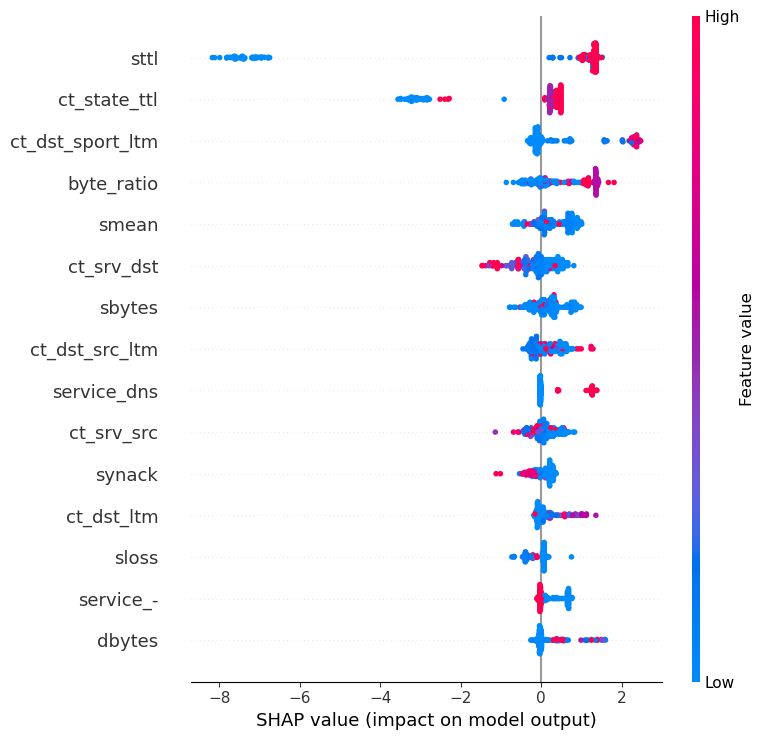

In [43]:
# Global SHAP summary of top features

shap.summary_plot(
    shap_values,
    X_shap,
    max_display=15  # only show top 15 most important features
)

In [44]:
# Single-flow explanation (SHAP force plot)

# Here I explain one malicious test flow. The red bars show features that push the prediction towards “attack”, and blue bars show features pushing it back towards “benign”.


Single malicious sample shape: (1, 194)


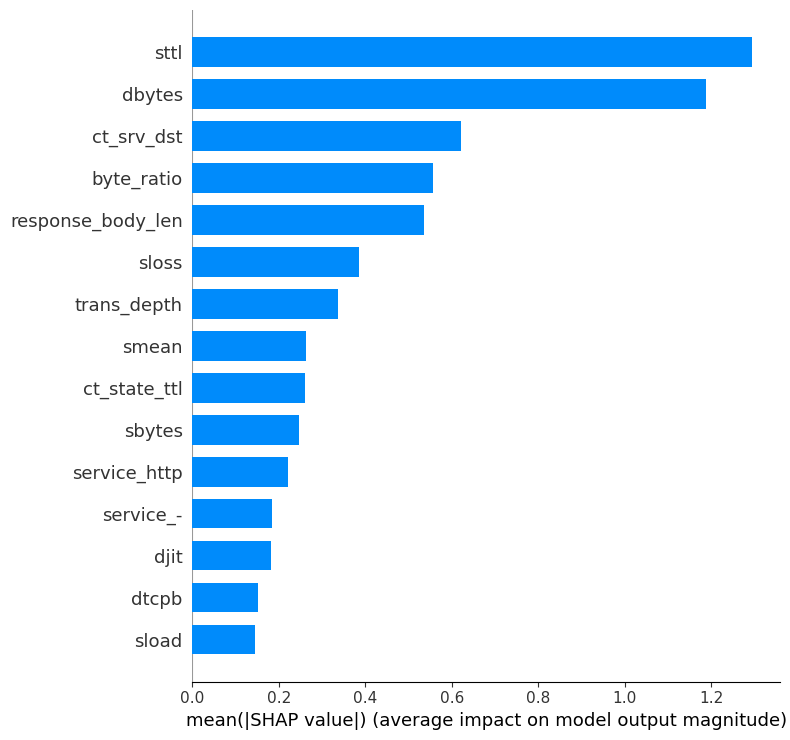

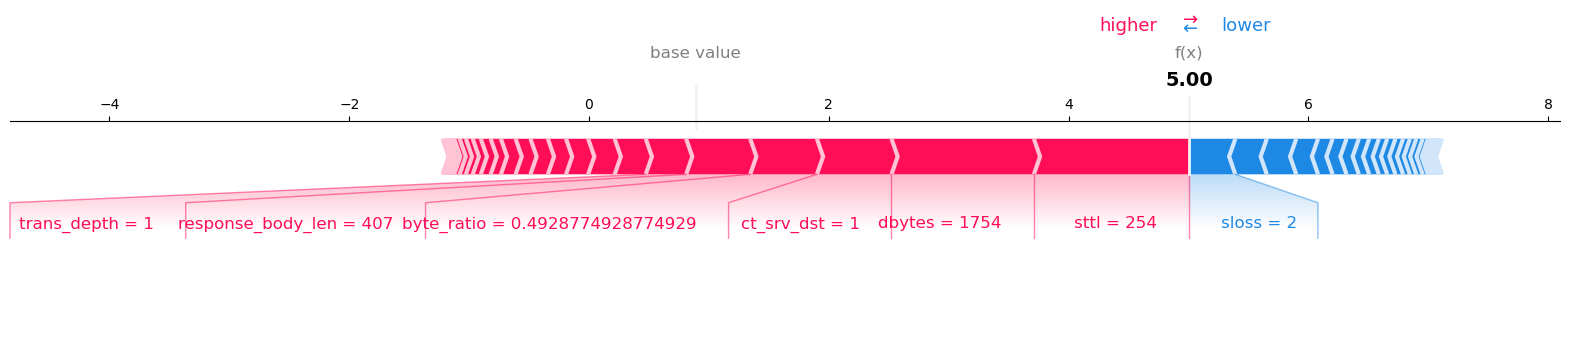

In [45]:
# SHAP explanation for a single malicious flow

# Find one malicious example in the test set
mal_idx = y_test[y_test == 1].index[0]
x_one = X_test.loc[[mal_idx]]

print("Single malicious sample shape:", x_one.shape)

# Compute SHAP values for that row
shap_vals_one = explainer.shap_values(x_one)

# Bar-style feature impact plot for this specific flow
shap.summary_plot(
    shap_vals_one,
    x_one,
    plot_type="bar",
    max_display=15  # top 15 features affecting this one prediction
)
# Display force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_vals_one,
    x_one,
    matplotlib=True
)

In [46]:
# Single-flow explanation (SHAP force plot – benign example)

# This plot explains why a normal (benign) network flow is classified as safe. Blue contributions push the prediction toward “benign” while red contributions are weak or absent.


Explaining benign sample index: 9873


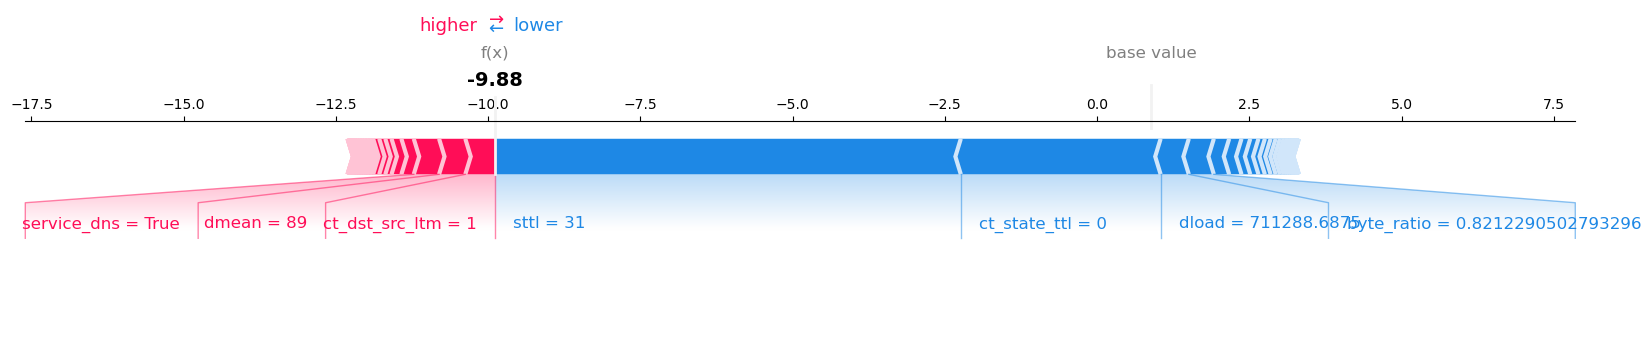

In [47]:
# SHAP explanation for a BENIGN traffic sample

# Find one benign test example (label == 0)
benign_idx = y_test[y_test == 0].index[0]
X_benign = X_test.loc[[benign_idx]]

print("Explaining benign sample index:", benign_idx)

# Calculate SHAP values for this benign sample
shap_values_benign = explainer.shap_values(X_benign)

# Display force plot
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values_benign,
    X_benign,
    matplotlib=True
)

In [48]:
# Step 10 – AI-Driven Anomaly Detection (Isolation Forest)

# Here I add an unsupervised anomaly detection model on top of the main XGBoost classifier.

# The idea is: - Train an Isolation Forest on the **feature space** so it learns what “normal” traffic looks like.
# - Use it to flag **unusual flows** as anomalies, even if they are not labeled as attacks.
# - Compare anomaly flags with the true UNSW labels to see how well it catches malicious traffic.

# This acts as a second layer of defense: the XGBoost model focuses on known patterns, while the anomaly detector can highlight “weird” traffic that may represent new or rare attacks.


In [49]:
# Train Isolation Forest on network flows

from sklearn.ensemble import IsolationForest
import numpy as np

# I treat most of X_train as "normal" traffic and let the model learn typical patterns.
# contamination is my rough guess of how much of the data may be anomalous.
iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,   # ~5% anomalous flows (tunable)
    random_state=42,
    n_jobs=-1
)

print("Fitting Isolation Forest on X_train...")
iso.fit(X_train)

# Predict on test set: 1 = normal, -1 = anomaly
if_pred = iso.predict(X_test)

# Convert to a simple 0/1 anomaly flag for analysis
anomaly_flag = (if_pred == -1).astype(int)  # 1 = anomaly, 0 = normal

print("Done. Example predictions:", np.unique(if_pred, return_counts=True))
print("Anomaly flag counts (0 = normal, 1 = anomaly):")
print(np.unique(anomaly_flag, return_counts=True))

Fitting Isolation Forest on X_train...
Done. Example predictions: (array([-1,  1]), array([ 1696, 33373]))
Anomaly flag counts (0 = normal, 1 = anomaly):
(array([0, 1]), array([33373,  1696]))


In [50]:
# How well does the anomaly detector catch malicious flows?

import pandas as pd

y_test_array = y_test.values  # make sure it's a NumPy array

# Basic counts
total_flows      = len(y_test_array)
total_malicious  = int((y_test_array == 1).sum())
total_benign     = int((y_test_array == 0).sum())

anomalies_total  = int((anomaly_flag == 1).sum())
anomalies_on_mal = int(((anomaly_flag == 1) & (y_test_array == 1)).sum())
anomalies_on_ben = int(((anomaly_flag == 1) & (y_test_array == 0)).sum())

print(f"Total test flows:        {total_flows}")
print(f"  Malicious (label=1):   {total_malicious}")
print(f"  Benign    (label=0):   {total_benign}")
print()
print(f"Total anomalies flagged by Isolation Forest: {anomalies_total}")
print(f"  Anomalies on malicious flows: {anomalies_on_mal}")
print(f"  Anomalies on benign flows:    {anomalies_on_ben}")

# Optional: small summary table for screenshots
summary_df = pd.DataFrame({
    "Metric": [
        "Total test flows",
        "Malicious flows (label=1)",
        "Benign flows (label=0)",
        "Anomalies (all)",
        "Anomalies on malicious flows",
        "Anomalies on benign flows",
    ],
    "Count": [
        total_flows,
        total_malicious,
        total_benign,
        anomalies_total,
        anomalies_on_mal,
        anomalies_on_ben,
    ]
})

summary_df

Total test flows:        35069
  Malicious (label=1):   23869
  Benign    (label=0):   11200

Total anomalies flagged by Isolation Forest: 1696
  Anomalies on malicious flows: 1108
  Anomalies on benign flows:    588


,Metric,Count
0,Total test flows,35069
1,Malicious flows (label=1),23869
2,Benign flows (label=0),11200
3,Anomalies (all),1696
4,Anomalies on malicious flows,1108
5,Anomalies on benign flows,588


In [51]:
# Inspect example anomalous network flows

# Build a small inspection table
inspect_df = X_test.copy()
inspect_df["true_label"] = y_test.values
inspect_df["anomaly_flag"] = anomaly_flag   # 1 = anomaly

# Filter only anomalies
anomaly_samples = inspect_df[inspect_df["anomaly_flag"] == 1]

print("Total anomalous flows detected:", len(anomaly_samples))

# Show first 5 anomalies for visual inspection
preview_cols = list(X_test.columns[:8]) + ["true_label", "anomaly_flag"]

print("\nSample anomalous flows:")
anomaly_samples[preview_cols].head(5)

Total anomalous flows detected: 1696

Sample anomalous flows:


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,true_label,anomaly_flag
64040,3.729340,256,54,310819,3226,82.856482,62,252,1,1
86759,59.918247,930,394,418500,16942,22.080085,254,252,1,1
103156,59.760056,180,0,48960,0,2.995312,254,0,1,1
45861,8.350656,8,0,360,0,0.838258,254,0,0,1
126733,32.572971,20,12,3292,536,0.951709,254,252,1,1


In [52]:
# Step 11 – SageMaker Pipeline for Automated Retraining

# Here I wrap the XGBoost training logic into a SageMaker Pipeline. The pipeline uses the same S3 training data and can be re-run to automatically retrain the model. I also list pipeline executions and inspect the status and steps of the latest run.


In [53]:
# Set up estimator for a SageMaker Pipeline (automated retraining)

import sagemaker
from sagemaker import image_uris
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import TrainingStep
from sagemaker.workflow.parameters import ParameterString
from sagemaker.inputs import TrainingInput

session = sagemaker.Session()
region = session.boto_region_name
role = sagemaker.get_execution_role()

bucket = "msml650-project"

xgb_image = image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.5-1",
)

output_path = f"s3://{bucket}/pipeline-model-output"

xgb_estimator = sagemaker.estimator.Estimator(
    image_uri=xgb_image,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    volume_size=5,
    output_path=output_path,
    sagemaker_session=session,
)

xgb_estimator.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="auc",
    num_round=200,
    max_depth=5,
    eta=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
)
print("Estimator for pipeline is ready.")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Estimator for pipeline is ready.


In [54]:
# Create a TrainingStep and build the SageMaker Pipeline

training_instance_type = ParameterString(
    name="TrainingInstanceType",
    default_value="ml.m5.large"
)

step_train = TrainingStep(
    name="TrainUNSWXGBoost",
    estimator=xgb_estimator,
    inputs={
        "train": TrainingInput(
            s3_data=f"s3://{bucket}/xgboost-data/train/unsw_train.libsvm",
            content_type="text/libsvm"
        ),
        "validation": TrainingInput(
            s3_data=f"s3://{bucket}/xgboost-data/test/unsw_test.libsvm",
            content_type="text/libsvm"
        ),
    },
)

pipeline_name = "unsw-xgb-pipeline"

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[training_instance_type],
    steps=[step_train],
    sagemaker_session=session,
)
print("Pipeline object created:", pipeline_name)

Pipeline object created: unsw-xgb-pipeline


In [55]:
# Upsert the pipeline definition and start an execution

execution = None

pipeline.upsert(role_arn=role)
print("Pipeline upserted.")

execution = pipeline.start()
print("Pipeline execution started:", execution.arn)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.


Pipeline upserted.
Pipeline execution started: arn:aws:sagemaker:us-east-1:710271916019:pipeline/unsw-xgb-pipeline/execution/b9x0coql02ly


In [56]:
# Basic pipeline inspection: list pipelines

import boto3
sm = boto3.client("sagemaker")

sm.list_pipelines()

{'PipelineSummaries': [{'PipelineArn': 'arn:aws:sagemaker:us-east-1:710271916019:pipeline/unsw-xgb-pipeline',
   'PipelineName': 'unsw-xgb-pipeline',
   'PipelineDisplayName': 'unsw-xgb-pipeline',
   'RoleArn': 'arn:aws:iam::710271916019:role/SageMakerCybersecurityRole',
   'CreationTime': datetime.datetime(2025, 11, 27, 20, 56, 3, 41000, tzinfo=tzlocal()),
   'LastModifiedTime': datetime.datetime(2025, 12, 1, 15, 2, 22, 385000, tzinfo=tzlocal()),
   'LastExecutionTime': datetime.datetime(2025, 12, 1, 15, 2, 22, 385000, tzinfo=tzlocal())}],
 'ResponseMetadata': {'RequestId': '340c7ff3-59e6-4f5a-b4b1-6231a6b840a4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '340c7ff3-59e6-4f5a-b4b1-6231a6b840a4',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 

In [57]:
# List executions for the UNSW XGBoost pipeline

sm.list_pipeline_executions(PipelineName="unsw-xgb-pipeline")

{'PipelineExecutionSummaries': [{'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:710271916019:pipeline/unsw-xgb-pipeline/execution/b9x0coql02ly',
   'StartTime': datetime.datetime(2025, 12, 1, 15, 2, 22, 317000, tzinfo=tzlocal()),
   'PipelineExecutionStatus': 'Executing',
   'PipelineExecutionDisplayName': 'execution-1764601342385'},
  {'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:710271916019:pipeline/unsw-xgb-pipeline/execution/4b2nz1cpg6nz',
   'StartTime': datetime.datetime(2025, 11, 30, 22, 59, 13, 293000, tzinfo=tzlocal()),
   'PipelineExecutionStatus': 'Succeeded',
   'PipelineExecutionDisplayName': 'execution-1764543553436'},
  {'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:710271916019:pipeline/unsw-xgb-pipeline/execution/9ab48bhetug2',
   'StartTime': datetime.datetime(2025, 11, 30, 22, 15, 56, 241000, tzinfo=tzlocal()),
   'PipelineExecutionStatus': 'Succeeded',
   'PipelineExecutionDisplayName': 'execution-1764540956330'},
  {'PipelineExecutionArn': 'ar

In [58]:
# List steps for the most recent pipeline execution (simple version)

exe = sm.list_pipeline_executions(PipelineName="unsw-xgb-pipeline")
execution_arn = exe["PipelineExecutionSummaries"][0]["PipelineExecutionArn"]

sm.list_pipeline_execution_steps(PipelineExecutionArn=execution_arn)

{'PipelineExecutionSteps': [],
 'ResponseMetadata': {'RequestId': 'ca8b1714-a3de-4661-828e-c7a63c5b333f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ca8b1714-a3de-4661-828e-c7a63c5b333f',
   'strict-transport-security': 'max-age=47304000; includeSubDomains',
   'x-frame-options': 'DENY',
   'content-security-policy': "frame-ancestors 'none'",
   'cache-control': 'no-cache, no-store, must-revalidate',
   'x-content-type-options': 'nosniff',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '29',
   'date': 'Mon, 01 Dec 2025 15:02:23 GMT'},
  'RetryAttempts': 0}}

In [59]:
# Detailed pipeline execution status and steps (combined)

import boto3, json

sm = boto3.client("sagemaker")

# 1. Get latest execution ARN (first one in the list)
exe_list = sm.list_pipeline_executions(PipelineName="unsw-xgb-pipeline")
latest_arn = exe_list["PipelineExecutionSummaries"][0]["PipelineExecutionArn"]
print("Latest execution ARN:", latest_arn)

# 2. List the steps inside that execution
steps = sm.list_pipeline_execution_steps(PipelineExecutionArn=latest_arn)

print(json.dumps(steps, indent=2, default=str))

Latest execution ARN: arn:aws:sagemaker:us-east-1:710271916019:pipeline/unsw-xgb-pipeline/execution/b9x0coql02ly
{
  "PipelineExecutionSteps": [],
  "ResponseMetadata": {
    "RequestId": "89defc30-703e-4904-a1fd-61a4cd6724f2",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "x-amzn-requestid": "89defc30-703e-4904-a1fd-61a4cd6724f2",
      "strict-transport-security": "max-age=47304000; includeSubDomains",
      "x-frame-options": "DENY",
      "content-security-policy": "frame-ancestors 'none'",
      "cache-control": "no-cache, no-store, must-revalidate",
      "x-content-type-options": "nosniff",
      "content-type": "application/x-amz-json-1.1",
      "content-length": "29",
      "date": "Mon, 01 Dec 2025 15:02:23 GMT"
    },
    "RetryAttempts": 0
  }
}


In [60]:
# Step 12 – Autoscaling for the Real-Time Endpoint

# In this step I enable autoscaling for the deployed endpoint. I register the endpoint as a scalable target, attach a target-tracking policy based on `InvocationsPerInstance`, and verify the scaling configuration using the Application Auto Scaling APIs.


In [61]:
# Register the endpoint as an autoscaling target

import boto3

endpoint_name = "unsw-xgb-endpoint"
resource_id = f"endpoint/{endpoint_name}/variant/AllTraffic"

appscaling = boto3.client("application-autoscaling")

print("Resource ID for autoscaling:", resource_id)

# Register scalable target
resp_target = appscaling.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # instance count autoscaling
    MinCapacity=1,
    MaxCapacity=2,
)
print("Scalable target registered.")
print(resp_target)

Resource ID for autoscaling: endpoint/unsw-xgb-endpoint/variant/AllTraffic
Scalable target registered.
{'ScalableTargetARN': 'arn:aws:application-autoscaling:us-east-1:710271916019:scalable-target/056mce6118ddb75541eb84c645c31cedef0f', 'ResponseMetadata': {'RequestId': '88f0a140-9207-4660-af24-35dbddf4ba4a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '88f0a140-9207-4660-af24-35dbddf4ba4a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '131', 'date': 'Mon, 01 Dec 2025 15:02:24 GMT'}, 'RetryAttempts': 0}}


In [62]:
# Create an autoscaling policy for the endpoint

# Create target tracking scaling policy
policy_name = "unsw-xgb-endpoint-autoscaling-policy"

resp_policy = appscaling.put_scaling_policy(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyName=policy_name,
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 50.0,
        "PredefinedMetricSpecification": {
            "PredefinedMetricType": "SageMakerVariantInvocationsPerInstance"
        },
        "ScaleInCooldown": 60,
        "ScaleOutCooldown": 60,
    },
)

print("Scaling policy created.")
print("Policy ARN:", resp_policy["PolicyARN"])

Scaling policy created.
Policy ARN: arn:aws:autoscaling:us-east-1:710271916019:scalingPolicy:ce6118dd-b755-41eb-84c6-45c31cedef0f:resource/sagemaker/endpoint/unsw-xgb-endpoint/variant/AllTraffic:policyName/unsw-xgb-endpoint-autoscaling-policy


In [63]:
# Verify autoscaling configuration (targets and policies)

import json
import boto3

endpoint_name = "unsw-xgb-endpoint"
resource_id = f"endpoint/{endpoint_name}/variant/AllTraffic"

appscaling = boto3.client("application-autoscaling")

print("== Scalable target(s) ==")
resp_targets = appscaling.describe_scalable_targets(
    ServiceNamespace="sagemaker",
    ResourceIds=[resource_id],
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
)
print(json.dumps(resp_targets, indent=2, default=str))

print("\n== Scaling policy(ies) ==")
resp_policies = appscaling.describe_scaling_policies(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
)
print(json.dumps(resp_policies, indent=2, default=str))

== Scalable target(s) ==
{
  "ScalableTargets": [
    {
      "ServiceNamespace": "sagemaker",
      "ResourceId": "endpoint/unsw-xgb-endpoint/variant/AllTraffic",
      "ScalableDimension": "sagemaker:variant:DesiredInstanceCount",
      "MinCapacity": 1,
      "MaxCapacity": 2,
      "RoleARN": "arn:aws:iam::710271916019:role/aws-service-role/sagemaker.application-autoscaling.amazonaws.com/AWSServiceRoleForApplicationAutoScaling_SageMakerEndpoint",
      "CreationTime": "2025-12-01 15:02:24.587000+00:00",
      "SuspendedState": {
        "DynamicScalingInSuspended": false,
        "DynamicScalingOutSuspended": false,
        "ScheduledScalingSuspended": false
      },
      "ScalableTargetARN": "arn:aws:application-autoscaling:us-east-1:710271916019:scalable-target/056mce6118ddb75541eb84c645c31cedef0f"
    }
  ],
  "ResponseMetadata": {
    "RequestId": "21713350-7deb-4721-9d90-c7eb77a14341",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "x-amzn-requestid": "21713350-7deb-47